In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

In [97]:
data = pd.read_csv('/kaggle/input/autompg-dataset/auto-mpg.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [98]:
data.shape

(398, 9)

# dropping non-useful columns

In [99]:
data['Age'] = 83 - data['model year'] # getting actual age of the car\
data = data.drop(['model year', 'origin', 'car name'], axis = 1)
data.head()



,mpg,cylinders,displacement,horsepower,weight,acceleration,Age
0,18.0,8,307.0,130,3504,12.0,13
1,15.0,8,350.0,165,3693,11.5,13
2,18.0,8,318.0,150,3436,11.0,13
3,16.0,8,304.0,150,3433,12.0,13
4,17.0,8,302.0,140,3449,10.5,13


In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   Age           398 non-null    int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 21.9+ KB


In [101]:
data[data['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,Age
32,25.0,4,98.0,?,2046,19.0,12
126,21.0,6,200.0,?,2875,17.0,9
330,40.9,4,85.0,?,1835,17.3,3
336,23.6,4,140.0,?,2905,14.3,3
354,34.5,4,100.0,?,2320,15.8,2
374,23.0,4,151.0,?,3035,20.5,1


In [102]:
data['horsepower'] = data['horsepower'].replace('?', np.nan)
data['horsepower'] = data['horsepower'].fillna(data['horsepower'].median())
data['horsepower'] = data['horsepower'].astype(np.int)

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    int64  
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   Age           398 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 21.9 KB


# Bivariate Analysis

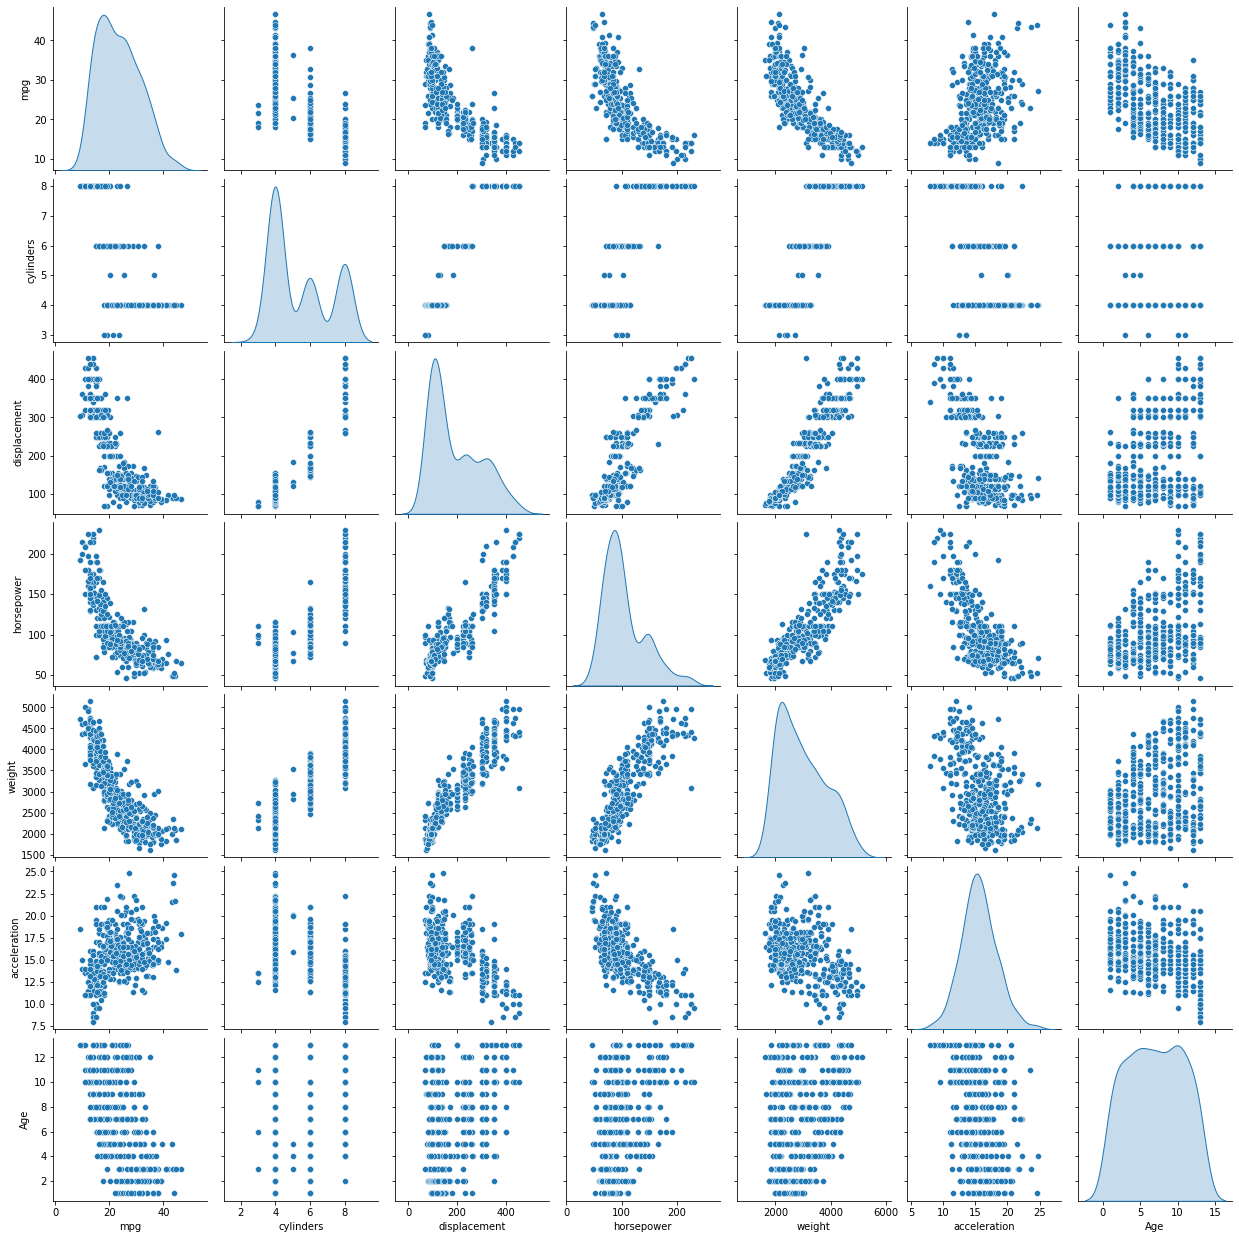

In [104]:
sns.pairplot(data, diag_kind = 'kde');

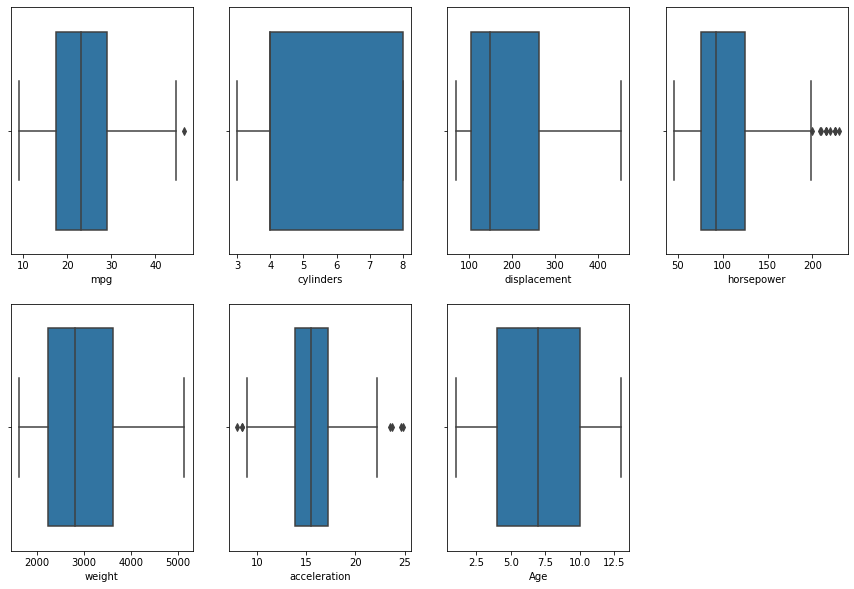

In [105]:
plt.figure(figsize = (15,10))
for i in enumerate(data.columns):
    plt.subplot(2,4, i[0]+1)
    sns.boxplot(data[i[1]])
plt.show()

> **mpg, horsepower and Acceleration having some outlier**

# Outlier removal using log

In [106]:
data['mpg'] = np.log(data['mpg'])
data['horsepower'] = np.log(data['horsepower'])
data['acceleration'] = np.log(data['acceleration'])

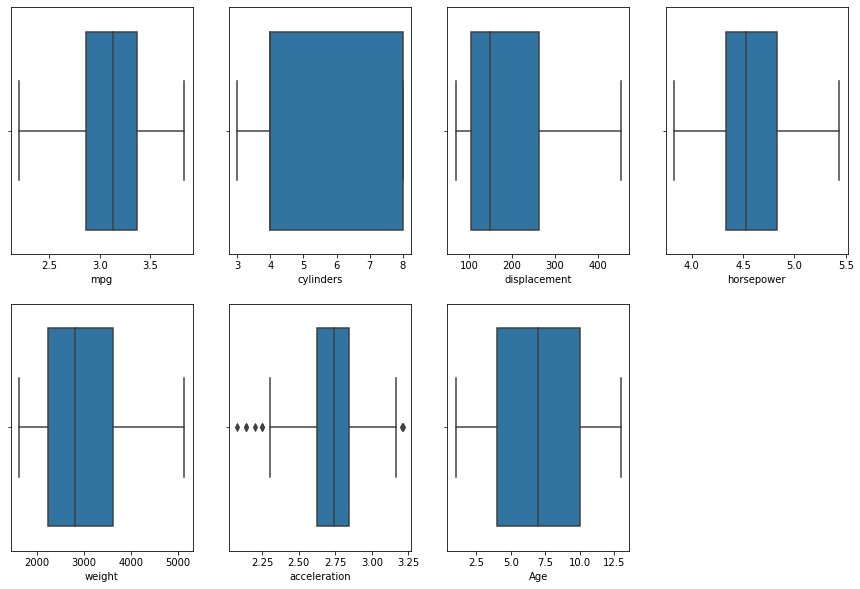

In [107]:
plt.figure(figsize = (15,10))
for i in enumerate(data.columns):
    plt.subplot(2,4, i[0]+1)
    sns.boxplot(data[i[1]])
plt.show()

> **now it looks satisfactory**

# Scaling Data using Zscore

In [108]:
new_data = data.apply(zscore)

In [109]:
new_data.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,Age
47,-0.462652,0.320935,0.543257,0.053091,0.368389,-0.117496,1.356642
145,1.074057,-0.856321,-1.060372,-1.398959,-1.143829,1.192135,0.544290
22,0.346349,-0.856321,-0.858718,-0.097588,-0.703997,0.736523,1.627426
395,1.074057,-0.856321,-0.561039,-0.459091,-0.798585,-1.541568,-1.621983
385,1.580647,-0.856321,-0.983552,-1.123356,-1.153288,0.308880,-1.621983


# Finding best K- value using Elbow method

In [110]:
k_range = range(1,15)
k_error = []
for k in k_range:
    clusters = KMeans(n_clusters = k, n_init = 5)
    clusters.fit(new_data)
    k_error.append(clusters.inertia_)
cluster_df = pd.DataFrame({'Clusters' : k_range, 'Errors' : k_error})
cluster_df

,Clusters,Errors
0,1,2786.000000
1,2,1257.890879
2,3,910.341541
3,4,719.116706
4,5,653.346870
5,6,581.862505
6,7,538.156689
7,8,490.611194
8,9,452.720742
9,10,422.179949


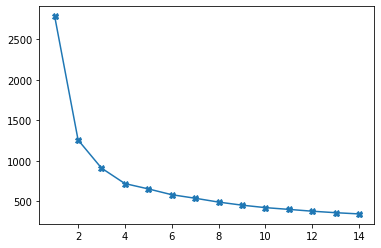

In [111]:
plt.plot(cluster_df.Clusters, cluster_df.Errors, marker = 'X')

> **K = 4 is the optimal elbow point**

# K-means model for K = 4

In [112]:
km = KMeans(n_clusters = 4, n_init = 5)
km.fit(new_data)

KMeans(n_clusters=4, n_init=5)

### Cheking no. of values in each cluster

In [113]:
labels = km.labels_
counts = np.bincount(labels[labels>=0])
counts

array([ 97,  94, 116,  91])

### Checking values of centroids

In [114]:
centroids = km.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns = list(new_data))
centroids_df.T

,0,1,2,3
mpg,0.319006,-1.306300,1.089601,-0.379616
cylinders,-0.850252,1.498191,-0.836023,0.424430
displacement,-0.800163,1.503923,-0.786534,0.302032
horsepower,-0.532218,1.442841,-0.818978,0.120874
weight,-0.756800,1.404098,-0.772604,0.341170
acceleration,0.315385,-1.150226,0.425782,0.309212
Age,0.683869,0.688324,-1.080415,-0.062743


# plotting predictions

In [115]:
new_data['group'] = km.predict(new_data)

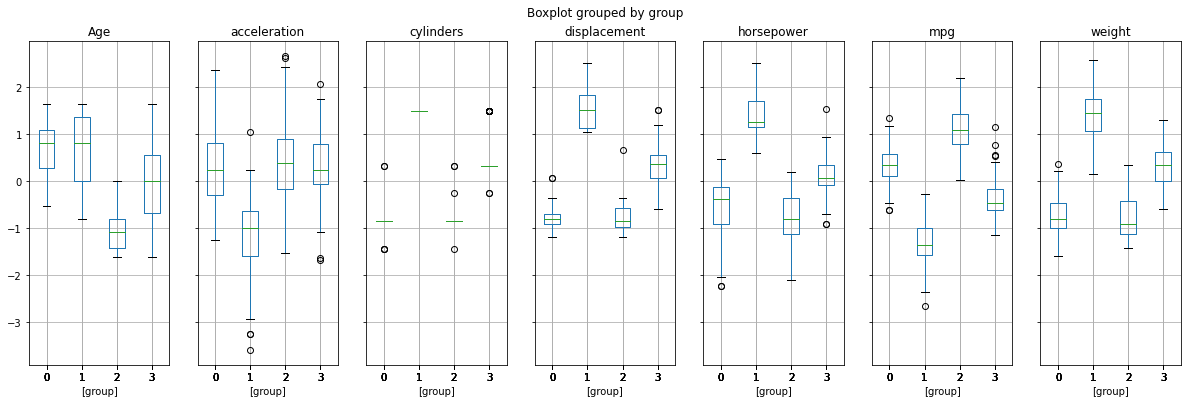

In [116]:
new_data.boxplot(by = 'group', layout = (1,7), figsize = (20,6))
plt.show()

# Hierarchical Clustering

In [117]:
H_data = new_data.drop('group', axis = 1)
H_data.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,Age
309,1.840375,-0.856321,-0.916334,-0.753098,-0.977119,-0.229423,-1.080415
197,0.783870,-0.856321,-0.993154,-0.994681,-1.221864,-0.421143,0.002721
43,-1.581334,1.498191,1.983643,1.611871,2.099342,-1.353748,1.356642
286,-0.688282,1.498191,1.042591,0.801131,0.892168,-0.742402,-0.809631
175,0.783870,-0.856321,-0.993154,-0.994681,-1.221864,-0.499728,0.273506


In [118]:
model = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'average')
model.fit(H_data)
H_data['labels'] = model.labels_
H_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,Age,labels
0,-0.622035,1.498191,1.090604,0.823816,0.630870,-1.353748,1.627426,1
1,-1.159493,1.498191,1.503514,1.524175,0.854333,-1.589535,1.627426,1
2,-0.622035,1.498191,1.196232,1.244190,0.550470,-1.835805,1.627426,1
3,-0.969242,1.498191,1.061796,1.244190,0.546923,-1.353748,1.627426,1
4,-0.790530,1.498191,1.042591,1.041516,0.565841,-2.093533,1.627426,1


In [119]:
clus_data = H_data.groupby(['labels']).mean()
clus_data

,mpg,cylinders,displacement,horsepower,weight,acceleration,Age
labels,,,,,,,
0,0.397531,-0.491172,-0.480458,-0.442655,-0.446054,0.339141,-0.195548
1,-1.265067,1.498191,1.471118,1.401619,1.369119,-1.099915,0.626346
2,1.992472,-0.856321,-0.976350,-2.044241,-0.989238,2.211291,-1.080415


# Checking Correlation between datapoints and dendrograms using cophenet

In [120]:
z = linkage(H_data, metric = 'euclidean', method = 'average')
c, cdist = cophenet(z, pdist(H_data))
c

0.8137491812204212

> **C closer to 1 is better**

> **0.8 is also good**

# Plotting Dendrograms

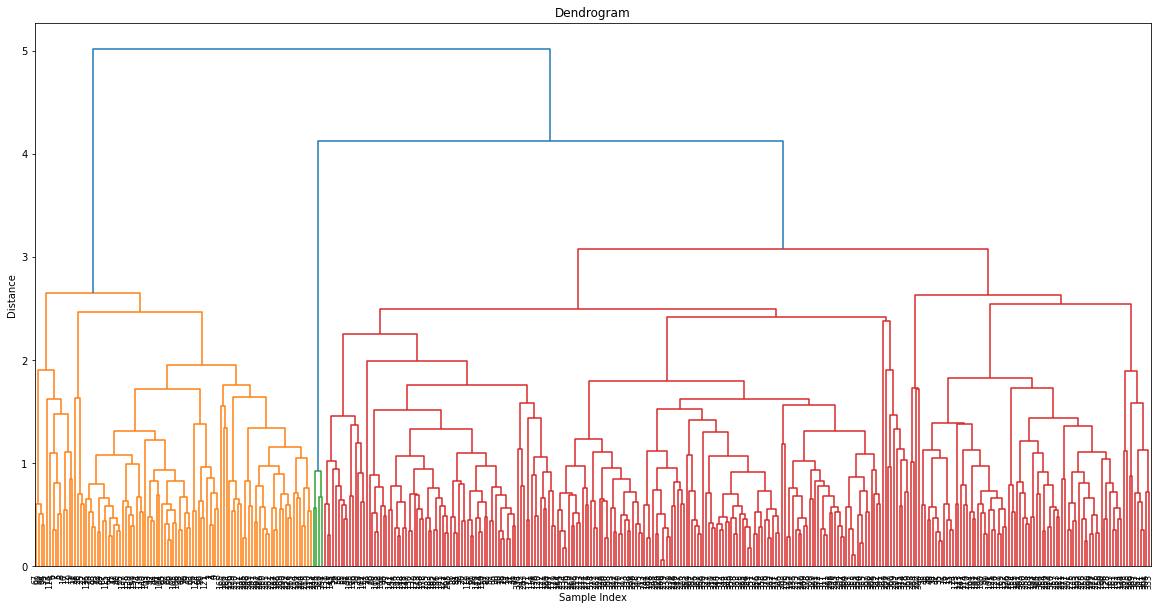

In [122]:
plt.figure(figsize = (20,10))
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(z, leaf_rotation = 90, leaf_font_size = 8)
plt.show()